# Gigs Senior Data Analyst Challenge

Welcome to the Gigs data analyst take-home challenge! This notebook will help you get started with analyzing our connectivity usage data.

## About the Data

You'll be working with three main datasets:
- **Usage Data**: Detailed usage per subscription period (~100K+ records)
- **Plan Events**: Plan configuration and pricing history
- **Projects**: Project metadata

## Setup Instructions

Run the cells below to set up your environment and load the data into DuckDB.

In [1]:
# Import required libraries
import duckdb
import pandas as pd
from datetime import datetime, timedelta

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [2]:
# Load JupySQL extension and configure
%load_ext sql

# Configure JupySQL for better output
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

print("✅ JupySQL configured!")

✅ JupySQL configured!


In [3]:
# Connect to DuckDB
conn = duckdb.connect('gigs-analytics.db')
%sql conn --alias duckdb

print("✅ Connected to DuckDB database: gigs-analytics.db")

✅ Connected to DuckDB database: gigs-analytics.db


In [4]:
%%sql
-- Load data into DuckDB tables
CREATE OR REPLACE TABLE usage_data AS 
SELECT * FROM 'data/usage_by_subscription_period.csv';

CREATE OR REPLACE TABLE plan_events AS 
SELECT * FROM 'data/plan_change_events.csv';

CREATE OR REPLACE TABLE projects AS 
SELECT * FROM 'data/projects.csv';

,Count
0,3


In [5]:
%%sql
-- Verify data loading
select 
  'usage_data' as table_name, 
  count(*) as row_count,
  count(distinct subscription_id) as unique_subscriptions
from usage_data
union all
select 
  'plan_events' as table_name, 
  count(*) as row_count,
  count(distinct plan_id) as unique_plans
from plan_events
union all
select 
  'projects' as table_name, 
  count(*) as row_count,
  count(distinct project_id__hashed) as unique_projects
from projects;

,table_name,row_count,unique_subscriptions
0,usage_data,53565,8457
1,plan_events,209,36
2,projects,3,3


## Your Analysis Starts Here!

Now you have everything set up. Use the cells below to start your analysis.

### Tips:
- Use `%%sql` for multi-line SQL queries
- Use `%%sql variable_name <<` to store results in a Python variable
- Combine SQL with Python/Pandas for advanced analysis
- Feel free to use any visualisation library you feel comfortable with

In [6]:
# Install required packages
!uv pip install matplotlib==3.10.7 lifelines==0.30.0

Audited 2 packages in 163ms


In [7]:
# Import required libraries
import seaborn as sns
import matplotlib.pyplot as plt

from lifelines import KaplanMeierFitter
from lifelines.statistics import pairwise_logrank_test

### Data Validation

Before starting the analysis, I want check if there are no issues with the data. I am looking for:

- **Duplicates**: I assume that the combination of subscription ID and either subscription_period, or subscription_period_start or subscription_period_start should be unique.
- **Completeness**: In order to perform a retention analyis, we should have complete sequence of periods for each subscription. I assume that period number should start at 1 and increase by 1 each subsequent period. Also, the period start should always be after the previous period has ended.
- **Inactive Subscriptions**: I assume that subscriptions that that have zero consumption (no data, no voice, no sms) can be safely removed from the dataset.
- **Outliers**: Look for outliers in the metrics. However, I am reluctant to remove outlier unless they are very obvious.

#### Duplicates

In [8]:
%%sql
-- Identify duplicate subscription_id/subscription_period_number combinations
select
    subscription_id,
    subscription_period_number,
    count(*) - 1 AS duplicates
from 
    usage_data
group by
    subscription_id, 
    subscription_period_number
having 
    duplicates > 0

,subscription_id,subscription_period_number,duplicates
0,sub_09fc9a36f53ced9cbed4052ba087,1,1
1,sub_4df055d769304d0c0b5020f3bf7b,3,1
2,sub_34d771b26da00b48f479e7a6c826,5,1
3,sub_3fbdfc4445770370e2a98bb6b623,10,1
4,sub_606958a0d9691fc364e134308780,2,1
...,...,...,...
81,sub_8062a013d7b67ba3e1a21e8db02f,3,1
82,sub_ed26be63b9889ef506d72cdf383c,2,1
83,sub_cdb3e517bdd5bc6ecc3db6db7b0a,3,1
84,sub_0a6c11a5aba96a01ff34f20a9f5d,4,1


In [9]:
%%sql
-- Identify duplicate subscription_id/subscription_period_start combinations
select
    subscription_id,
    subscription_period_start,
    count(*) - 1 AS duplicates
from 
    usage_data
group by
    subscription_id, 
    subscription_period_start
having 
    duplicates > 0

,subscription_id,subscription_period_start,duplicates
0,sub_c6f9840b6e587c0104081f83ad6b,2024-03-18,1
1,sub_8062a013d7b67ba3e1a21e8db02f,2024-03-30,1
2,sub_cdb3e517bdd5bc6ecc3db6db7b0a,2024-04-28,1
3,sub_0dd117a00ba2831e4b5cdf7632c8,2024-04-29,1
4,sub_399be383748edd1b51878affd835,2024-12-09,1
5,sub_9fbff0c2e0630d9f495aeeafe789,2025-01-25,1
6,sub_19cfdc102a0609df0ba8aa4e8781,2025-02-25,1
7,sub_32369cb853a992d6053e06866f6c,2024-11-25,1
8,sub_4a2da1d859b62ea22ec3ac480c61,2025-01-25,1
9,sub_e8881c07e78942b8f7b1a8474a43,2024-03-25,1


In [10]:
%%sql
-- Identify duplicate subscription_id/subscription_period_end combinations
select
    subscription_id,
    subscription_period_end,
    count(*) - 1 AS duplicates
from 
    usage_data
group by
    subscription_id, 
    subscription_period_end
having 
    duplicates > 0

,subscription_id,subscription_period_end,duplicates
0,sub_7cfc552eb675137a62cfa9023ab2,2025-02-28,1


##### Mitigating Action
Looks like there only are a few duplicates. Because we don't have time to fix this and we are only interested in averages, let's remove all subscriptions that contain duplicates. 

In [11]:
%%sql
create or replace table usage_data_dedup as 
with 
subscription_period_start_duplicates as (
    select
        subscription_id,
        subscription_period_start,
        count(*) - 1 AS duplicates
    from 
        usage_data
    group by
        subscription_id, 
        subscription_period_start
    having 
        duplicates > 0
),
subscription_period_end_duplicates as (
    select
        subscription_id,
        subscription_period_end,
        count(*) - 1 AS duplicates
    from 
        usage_data
    group by
        subscription_id, 
        subscription_period_end
    having 
        duplicates > 0
),
period_number_duplicates as (
    select
        subscription_id,
        subscription_period_number,
        count(*) - 1 AS duplicates
    from 
        usage_data
    group by
        subscription_id, 
        subscription_period_number
    having 
        duplicates > 0
),
subscriptions_with_duplicates AS (
    select subscription_id from subscription_period_start_duplicates
    union
    select subscription_id from subscription_period_end_duplicates
    union
    select subscription_id from period_number_duplicates
)
select
    *
from
    usage_data
where
    subscription_id not in (select subscription_id from subscriptions_with_duplicates)

,Count
0,53203


In [12]:
%%sql
-- Counting the number of remaining subscriptions
select count(distinct subscription_id) as Count from usage_data_dedup

,Count
0,8371


8371 of 8457 subscriptions remain in the dataset. That should be more than enough to perform the analysis.

#### Completeness

In [13]:
%%sql
-- Check for which subscriptions the first period number is not 1 
select 
    subscription_id, 
    min(subscription_period_number) as first_subscription_period_number 
from 
    usage_data_dedup 
group by 
    subscription_id
having
    first_subscription_period_number > 1 

,subscription_id,first_subscription_period_number
0,sub_ae14aa910dfc7470fdcf376504ad,2
1,sub_b213609616fdd50e3dbc41ef41ff,2
2,sub_00948ba353cb4696d7837e9568ce,3
3,sub_b516d881aef33a273e4ab5a5bc66,2
4,sub_e77ce21017cd103a6350a0f5f546,2
5,sub_dc7e2c7861145c0a1aadf1419c9f,2
6,sub_ec63299b06e3c12f0393199a2714,2
7,sub_d5a4637f3775a35e8583765e4496,2
8,sub_5fcce2fe700bf6bb70572b82e722,2
9,sub_713214372cde25f837fb98d8887f,2


In [14]:
%%sql
-- Check for which subscriptions the period number doesn't increase by 1 each subsequent period
with cte as (
select 
    subscription_id,
    subscription_period_number - COALESCE(
        lag(subscription_period_number) OVER (
            partition by 
                subscription_id 
            order by 
                subscription_period_number
        ), 0) AS increase
from
    usage_data_dedup
)
select 
    * 
from 
    cte
where 
    increase > 1

,subscription_id,increase
0,sub_0a838770654139b0ee5f66a3f542,7
1,sub_0b6a89f79eb6242dfea44c3e98f3,2
2,sub_156a0dd8506cbfcd9850bfd52125,2
3,sub_156a0dd8506cbfcd9850bfd52125,3
4,sub_156a0dd8506cbfcd9850bfd52125,2
...,...,...
223,sub_2ff8dad969fe02fba755edb3acc8,2
224,sub_2ff8dad969fe02fba755edb3acc8,2
225,sub_4b27e379a46954f4050857c6e828,3
226,sub_5ce29bff0c640b4b3d91437c24cf,3


In [15]:
%%sql
-- Check for which subscriptions the period start is before the previous period has ended.
with cte as (
select 
    subscription_id,
    datediff(
        'day',
        subscription_period_end,
        lead(subscription_period_start) OVER (PARTITION BY subscription_id ORDER BY subscription_period_number)
    ) AS increase
from
    usage_data_dedup
)
select 
    *
from 
    cte
where true
    and increase < 0 
    and increase is not null 

,subscription_id,increase


##### Mitigating Action

Looks like there only are a few subscriptions with incomplete data. Because we don't have time to fix this and we are only interested in averages, let's remove all subscriptions that have missing data.

In [16]:
%%sql
create or replace table usage_data_dedup_clean AS 
with 
stage as (
   select 
        *,
        lag(subscription_period_number) OVER (PARTITION BY subscription_id ORDER BY subscription_period_number) AS previous_subscription_period_number,
        lag(subscription_period_end) OVER (PARTITION BY subscription_id ORDER BY subscription_period_number) AS previous_subscription_period_end       
    from
        usage_data_dedup
),
subscription_start_missing as (
    select 
        subscription_id, 
        min(subscription_period_number) as first_subscription_period_number 
    from 
        stage 
    group by 
        subscription_id
    having 
        first_subscription_period_number > 1 
),
subscription_sequence_incomplete as (
    select 
        subscription_id
    from
        stage
    where true
        and subscription_period_number > 1
        and subscription_period_number - previous_subscription_period_number > 1 
        and subscription_period_start >= previous_subscription_period_end
),
subscriptions_with_incomplete_data AS (
    select subscription_id from subscription_start_missing
    union
    select subscription_id from subscription_sequence_incomplete
)
select
    *
from
    usage_data_dedup
where
    subscription_id not in (select subscription_id from subscriptions_with_incomplete_data)

,Count
0,52381


In [17]:
%%sql
-- Counting the number of remaining subscriptions
select count(distinct subscription_id) as Count from usage_data_dedup_clean

,Count
0,8245


8245 of 8457 subscriptions remain in the dataset. That should be more than enough to perform the analysis.

#### Inactive Subscriptions

In [18]:
%%sql
usage_data_df << 
-- I load the data into a pandas dataframe and continue from there. I also include the data allowance 
-- and organization name here because I will need them later.
select 
    ud.*,
    pe.plan_name,
    pe.data_allowance_mb,
    case when pe.is_unlimited_data 
        then 'Unlimited'
        else cast(cast(data_allowance_mb / 1000 as int) as varchar) || ' GB'
    end as data_allowance,
    organization_name
from  
    usage_data_dedup_clean as ud
left join 
    plan_events as pe
        on  ud.plan_id = pe.plan_id 
        and date_add(ud.subscription_period_start, interval 1 day) between pe._valid_from and coalesce(pe._valid_to, DATE('2100-01-01'))
left join
    projects as p
        on ud.project_id__hashed = p.project_id__hashed
order by 
    subscription_id, 
    subscription_period_number

In [19]:
# Check if the number of records in the same as in the usage_data_dedup_clean table
usage_data_df.shape

(52381, 15)

In [20]:
usage_data_df.head()

,subscription_id,project_id__hashed,plan_id,reporting_date,subscription_period_start,subscription_period_end,subscription_period_number,cumulative_data_usage_megabyte,cumulative_voice_usage_minutes,cumulative_sms_usage,number_of_addons_activated,plan_name,data_allowance_mb,data_allowance,organization_name
0,sub_0009fec38a009568937479c0c594,dace2786aee7632e61757b320a6fe5bff37a2e742fe558...,pln_b109c69e95246b6d535b9cc9174f,2025-05-28,2025-04-29,2025-05-29,1,791.233536,13.4,590.0,0,Ultra Unlimited,NaN,Unlimited,People Mobile
1,sub_000df9d850a8dd32e27f6d7cf0cc,82728d5d3cf7f35b58bc318399c2c5caf7eeadcc37f359...,pln_0a3b55b9abb575b023c07e617b49,2024-06-08,2024-05-09,2024-06-09,1,196.996096,434.0,664.0,0,Easy Plan,1000.0,1 GB,ACME Phone
2,sub_000df9d850a8dd32e27f6d7cf0cc,82728d5d3cf7f35b58bc318399c2c5caf7eeadcc37f359...,pln_0a3b55b9abb575b023c07e617b49,2024-07-08,2024-06-09,2024-07-09,2,142.422016,366.0,548.0,0,Easy Plan,1000.0,1 GB,ACME Phone
3,sub_000df9d850a8dd32e27f6d7cf0cc,82728d5d3cf7f35b58bc318399c2c5caf7eeadcc37f359...,pln_0a3b55b9abb575b023c07e617b49,2024-08-08,2024-07-09,2024-08-09,3,160.664576,844.0,1072.0,0,Easy Plan,1000.0,1 GB,ACME Phone
4,sub_000df9d850a8dd32e27f6d7cf0cc,82728d5d3cf7f35b58bc318399c2c5caf7eeadcc37f359...,pln_0a3b55b9abb575b023c07e617b49,2024-09-08,2024-08-09,2024-09-09,4,98.029568,714.0,1366.0,0,Easy Plan,1000.0,1 GB,ACME Phone


In [21]:
# I will create an indicator for whether a record belong to a active subscription here.
# An active subscription is subscription with has consumed either data, voice or sms in at least one period.
usage_data_df['is_subscription_active'] =\
    (usage_data_df.groupby(['subscription_id'])['cumulative_data_usage_megabyte'].transform('sum') > 0) |\
    (usage_data_df.groupby(['subscription_id'])['cumulative_voice_usage_minutes'].transform('sum') > 0) |\
    (usage_data_df.groupby(['subscription_id'])['cumulative_sms_usage'].transform('sum') > 0)

In [22]:
# Count active subscriptions
len(usage_data_df[usage_data_df['is_subscription_active']].subscription_id.unique())

7443

#### Outliers

In [23]:
usage_data_df.describe()

,reporting_date,subscription_period_start,subscription_period_end,subscription_period_number,cumulative_data_usage_megabyte,cumulative_voice_usage_minutes,cumulative_sms_usage,number_of_addons_activated,data_allowance_mb
count,52381,52381,52381,52381.000000,52381.000000,52381.000000,52381.000000,52381.000000,46895.000000
mean,2024-11-26 10:39:54.318550,2024-10-28 13:31:51.647353,2024-11-27 09:55:27.152975,5.584449,1429.586615,271.569813,317.575056,0.000611,1273.547286
min,2024-02-07 00:00:00,2024-01-21 00:00:00,2024-02-07 00:00:00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2024-08-24 00:00:00,2024-07-25 00:00:00,2024-08-25 00:00:00,2.000000,6.487040,0.000000,0.000000,0.000000,1000.000000
50%,2024-11-24 00:00:00,2024-10-25 00:00:00,2024-11-25 00:00:00,5.000000,135.432192,54.000000,82.000000,0.000000,1000.000000
75%,2025-03-13 00:00:00,2025-02-15 00:00:00,2025-03-14 00:00:00,8.000000,524.705792,331.000000,375.000000,0.000000,1000.000000
max,2025-06-16 00:00:00,2025-06-15 00:00:00,2025-06-17 00:00:00,16.000000,282946.536448,21101.000000,47566.000000,2.000000,5000.000000
std,NaN,NaN,NaN,3.735544,7945.636500,621.690793,910.030993,0.026209,1013.229076


I quickly used the describe function to see if there could be outliers, but there are no obvious outliersb. 
I will check again later when I plot the data

### Data Preparation
I now have some confidence in the dataset and will prepare it to answer the business questions. All business question are on the subscription level, so I will aggregate the data to this level.

**Churn definition**: The last question is about retention. This requires a definition of churn. Since the data only contains completed periods and most periods last a month or 30 days, I assumed that subscriptions that have a period end in the 31 days prior to the last date in the dataset have not churned. This is of course not a perfect definition, but should be good enough for an initial analysis.

In [24]:
# Mask for active subscriptions with data plan
mask = usage_data_df['is_subscription_active'] & (usage_data_df['plan_name'] != 'No Allowances Plan')

# Calculated the number of days in each period
usage_data_df['subscription_period_days'] = (usage_data_df['subscription_period_end'] - usage_data_df['subscription_period_start']).dt.days

# Group all the metrics per active subscription
subscription_df = usage_data_df[mask]\
    .groupby(['subscription_id', 'data_allowance', 'organization_name']).agg({
            'cumulative_data_usage_megabyte': 'sum', 
            'subscription_period_days': 'sum',
            'subscription_period_number': 'max',
            'subscription_period_end': 'max' 
        })\
    .reset_index()

# Calculate data consumption per day
subscription_df['cumulative_data_usage_megabyte_per_day'] =\
    (subscription_df['cumulative_data_usage_megabyte'] / subscription_df['subscription_period_days'])

# Churn
subscription_df['is_churned'] =\
    (subscription_df['subscription_period_end'].max() - subscription_df['subscription_period_end']).dt.days > 31 

### How much data does a subscription typically consume?

**GenAI usage**: First version of this code was generated using ChatGPT. I instructed ChatGPT to create an histogram with seaborn and have ref lines for the mean and median. I also made tweaks to improve the interpretability. 

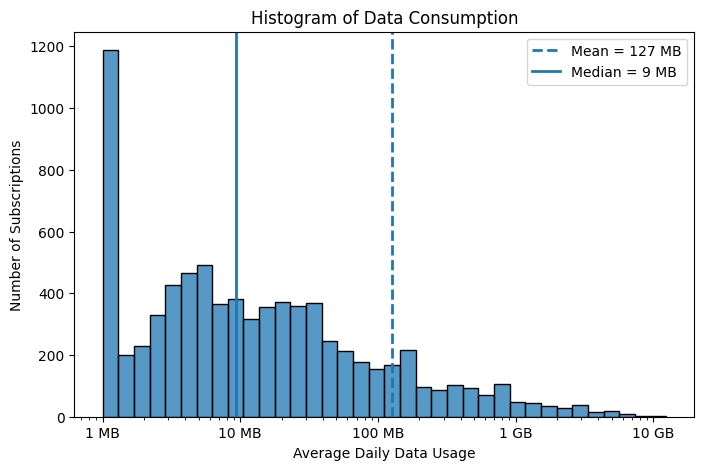

In [25]:
# Calculate mean and median
mean_val = subscription_df['cumulative_data_usage_megabyte_per_day'].mean()
median_val = subscription_df['cumulative_data_usage_megabyte_per_day'].median()

plt.figure(figsize=(8, 5))
# Create  histogram
g = sns.histplot(
    x=subscription_df['cumulative_data_usage_megabyte_per_day'].clip(1), 
    log_scale=True,
)
g.set_title('Histogram of Data Consumption')
g.set_xlabel('Average Daily Data Usage')
g.set_ylabel('Number of Subscriptions')

# Dynamically create tick positions and labels
ticks = [1, 10, 100, 1000, 10000]
labels = ['1 MB',  '10 MB', '100 MB', '1 GB', '10 GB']
g.set_xticks(ticks)
g.set_xticklabels(labels)

# Add mean and median lines
plt.axvline(mean_val, linestyle='--', linewidth=2, label=f"Mean = {mean_val:.0f} MB")
plt.axvline(median_val, linestyle='-', linewidth=2, label=f"Median = {median_val:.0f} MB")
plt.legend()
plt.show()

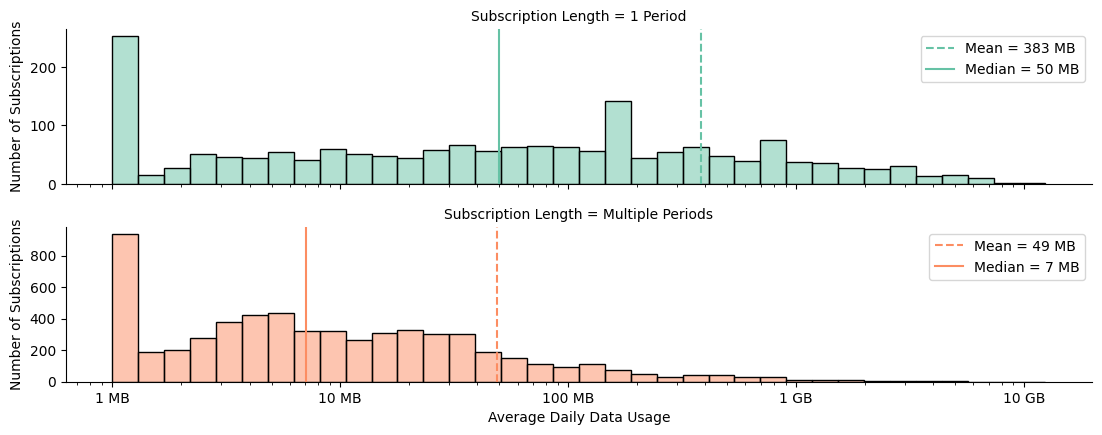

In [27]:
subscription_df['Subscription Length'] = subscription_df['subscription_period_days'].map(lambda x: '1 Period' if x <= 31 else 'Multiple Periods')

# Preserve the category order of appearance 
order = ['1 Period', 'Multiple Periods']

# Choose a palette name or provide a list of colors
palette = 'Set2'
colors = sns.color_palette(palette, n_colors=len(order))
palette_map = dict(zip(order, colors))  # map group -> color

# Seaborn histogram
g = sns.displot(
    subscription_df, 
    x=subscription_df['cumulative_data_usage_megabyte_per_day'].clip(1), 
    row='Subscription Length',
    row_order=order,
    hue='Subscription Length', 
    hue_order=order,
    log_scale=True, 
    facet_kws={'sharey': False},
    aspect=5, 
    height=2.25, 
    palette=palette
)
g.set_axis_labels(x_var='Average Daily Data Usage', y_var='Number of Subscriptions', clear_inner=True)
g._legend.remove()

# Dynamically create tick positions and labels
ticks = [1, 10, 100, 1000, 10000]
labels = ['1 MB',  '10 MB', '100 MB', '1 GB', '10 GB']
g.axes.flatten()[0].set_xticks(ticks)
g.axes.flatten()[0].set_xticklabels(labels)

for ax, group in zip(g.axes.flat, order):
    group_df = subscription_df[subscription_df['Subscription Length'] == group]
    
    mean_val = group_df['cumulative_data_usage_megabyte_per_day'].mean()
    median_val = group_df['cumulative_data_usage_megabyte_per_day'].median()
    
    ax.axvline(mean_val,   color=palette_map[group], linestyle="--", label=f"Mean = {mean_val:.0f} MB")
    ax.axvline(median_val, color=palette_map[group], linestyle="-", label=f"Median = {median_val:.0f} MB")
    ax.legend()
    
# plt.savefig('histogram_data_consumption.png')

### How does usage look like at different plan data allowances?

**GenAI usage**: First version of this code was generated using ChatGPT. I instructed ChatGPT to create histograms in a facet grid with seaborn and have ref lines for the mean and median. I also made tweaks to improve the interpretability. 

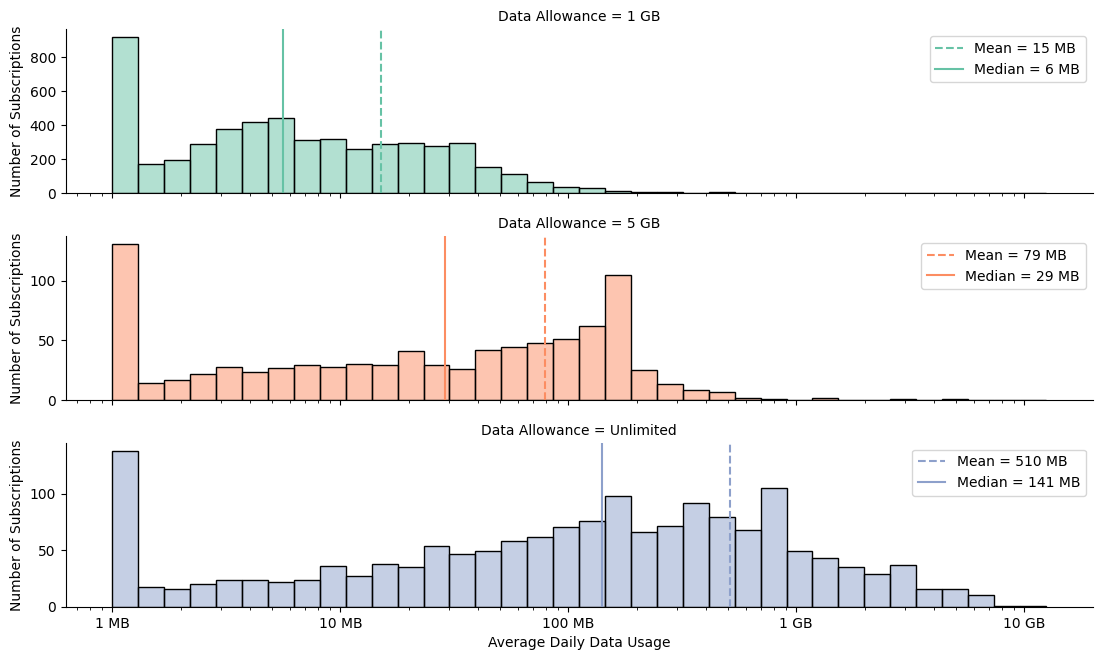

In [28]:
# Preserve the category order of appearance 
order = ['1 GB', '5 GB', 'Unlimited']

# Choose a palette name or provide a list of colors
palette = 'Set2'
colors = sns.color_palette(palette, n_colors=len(order))
palette_map = dict(zip(order, colors))  # map group -> color

# Seaborn histogram
g = sns.displot(
    subscription_df.rename(columns={'data_allowance': 'Data Allowance'}), 
    x=subscription_df['cumulative_data_usage_megabyte_per_day'].clip(1), 
    row='Data Allowance',
    row_order=order,
    hue='Data Allowance', 
    hue_order=order,
    log_scale=True, 
    facet_kws={'sharey': False},
    aspect=5, 
    height=2.25, 
    palette=palette
)
g.set_axis_labels(x_var='Average Daily Data Usage', y_var='Number of Subscriptions', clear_inner=True)
g._legend.remove()

# Dynamically create tick positions and labels
ticks = [1, 10, 100, 1000, 10000]
labels = ['1 MB',  '10 MB', '100 MB', '1 GB', '10 GB']
g.axes.flatten()[0].set_xticks(ticks)
g.axes.flatten()[0].set_xticklabels(labels)

for ax, group in zip(g.axes.flat, order):
    group_df = subscription_df[subscription_df['data_allowance'] == group]
    
    mean_val = group_df['cumulative_data_usage_megabyte_per_day'].mean()
    median_val = group_df['cumulative_data_usage_megabyte_per_day'].median()
    
    ax.axvline(mean_val,   color=palette_map[group], linestyle="--", label=f"Mean = {mean_val:.0f} MB")
    ax.axvline(median_val, color=palette_map[group], linestyle="-", label=f"Median = {median_val:.0f} MB")
    ax.legend()

# plt.savefig('histogram_data_consumption_per_project.png')

### Compare the retention pattern for the most recently launched project versus the two older ones.

**GenAI usage**: First version of this code was generated using ChatGPT. I instructed ChatGPT to use a non-parametric surival model.

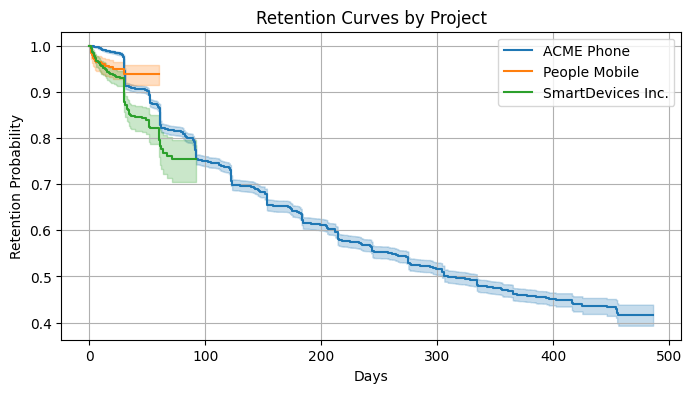

                                 test_statistic             p   -log2(p)
ACME Phone    People Mobile            0.413013  5.204443e-01   0.942184
              SmartDevices Inc.       37.075836  1.136231e-09  29.713097
People Mobile SmartDevices Inc.       13.284631  2.675906e-04  11.867685


In [30]:
# df columns:
#   time  - duration until event/censor
#   event - 1 if event occurred, 0 if censored
#   group - categorical group label

# Change the subscription_df to match the expected df
df = subscription_df[['subscription_period_days','is_churned', 'organization_name']]\
    .rename(columns={
        'subscription_period_days': 'time',
        'is_churned': 'event',
        'organization_name': 'group'
    })
df['event'] = df['event'].astype(int)

kmf = KaplanMeierFitter()

plt.figure(figsize=(8, 4))

# Plot KM curve for each group
for name, grouped_df in df.groupby("group"):
    kmf.fit(
        durations=grouped_df["time"],
        event_observed=grouped_df["event"],
        label=str(name)
    )
    kmf.plot()

plt.title("Retention Curves by Project")
plt.xlabel("Days")
plt.ylabel("Retention Probability")
plt.grid(True)
plt.show()
# plt.savefig('retention_curves.png')

# Pairwise log-rank tests across all groups
results = pairwise_logrank_test(
    df["time"],
    df["group"],
    df["event"]
)

print(results.summary)